RMSE:                2991.800
MAE:                 471.099
Median AE:           120.960
R²:                  0.926
Explained Variance:  0.926
MAPE:                9.56%
Within ±10% accuracy:65.97%


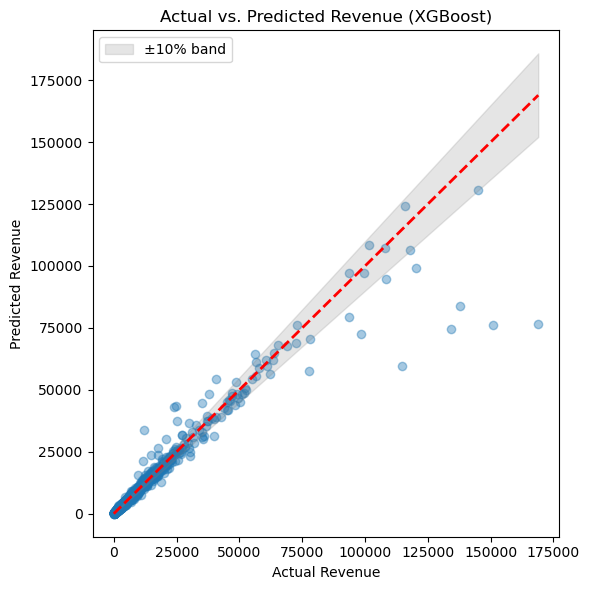

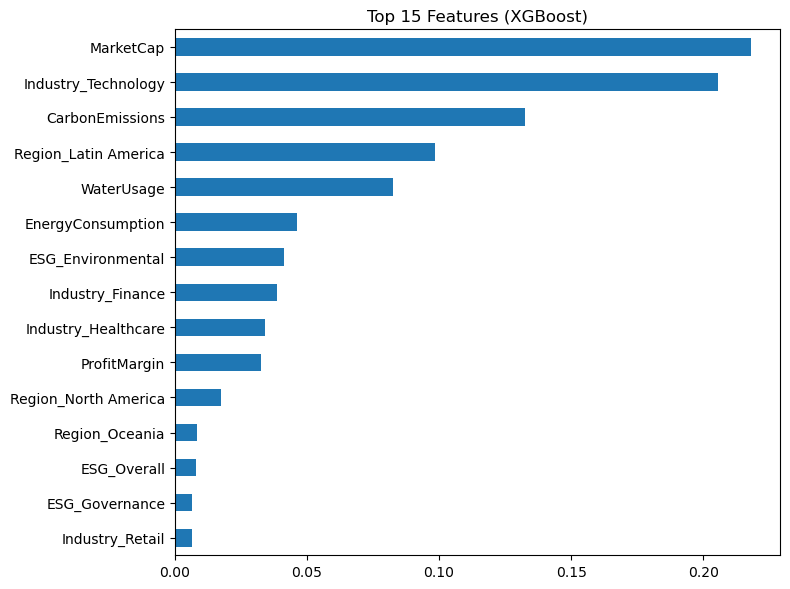

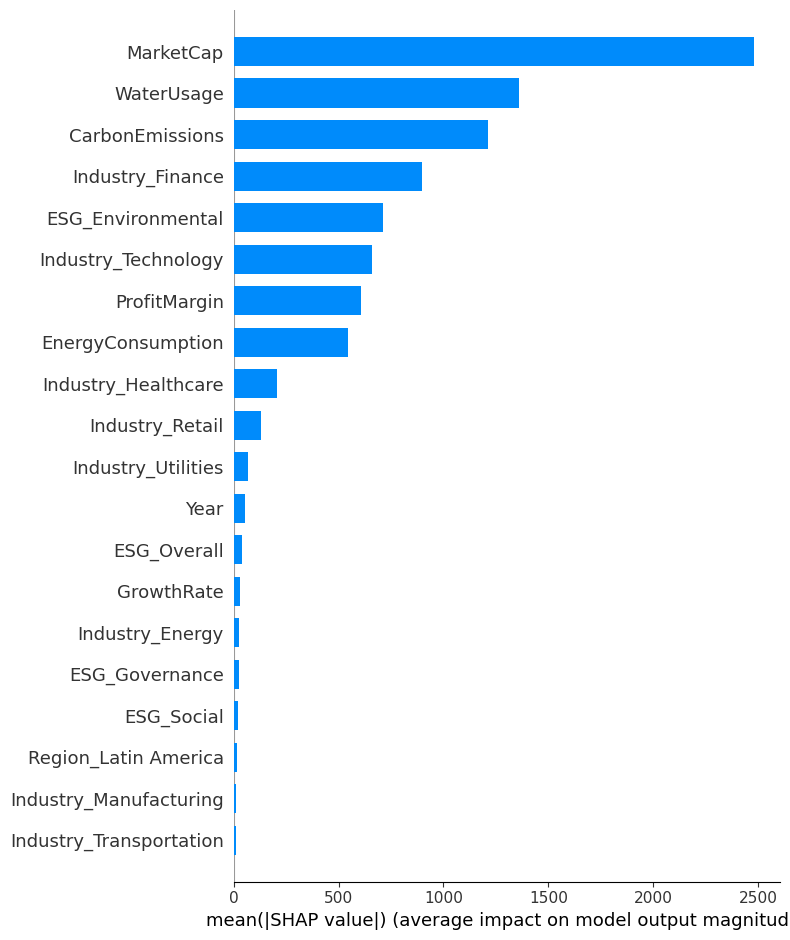

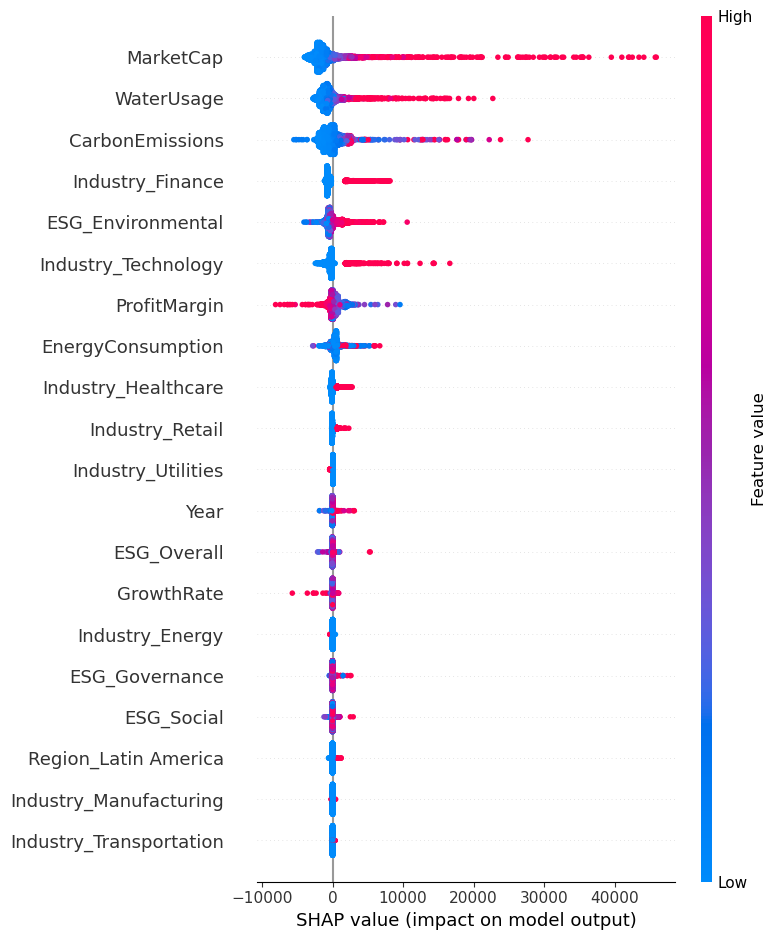

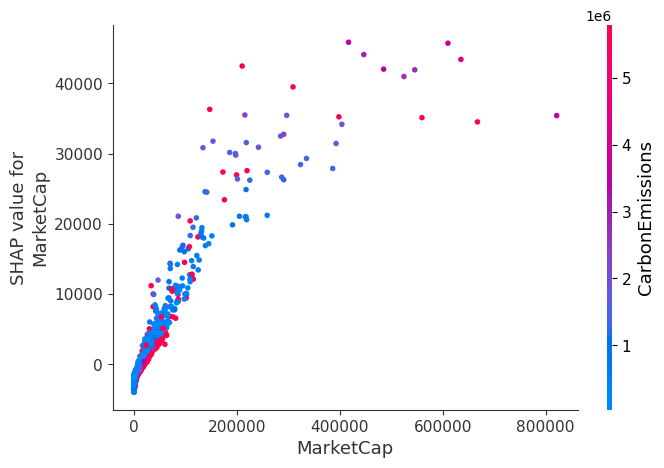

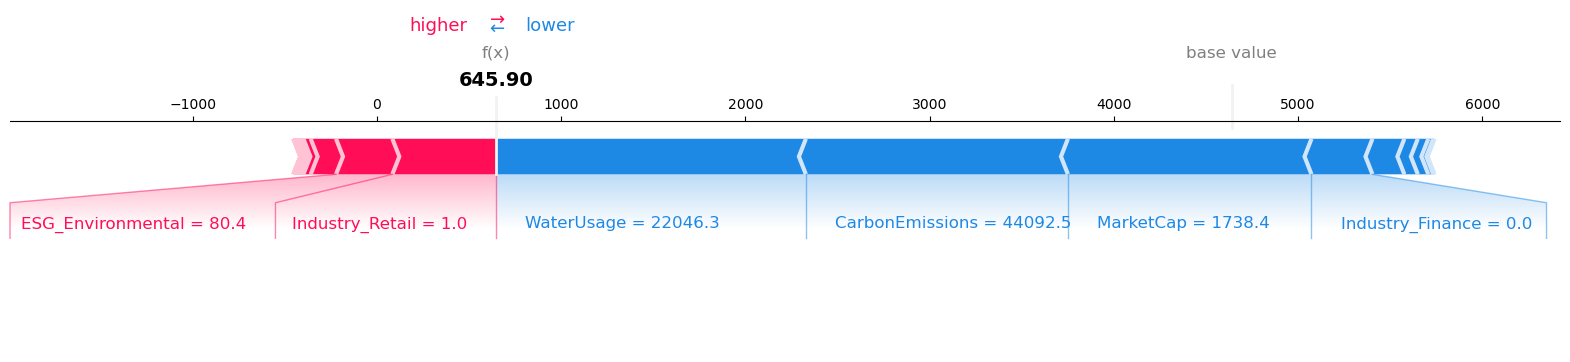

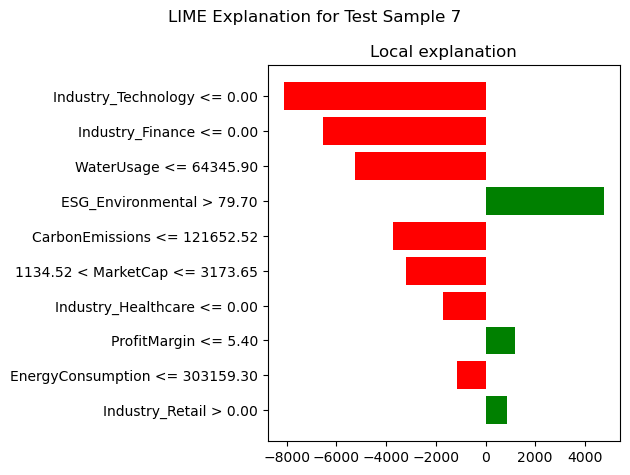

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score,
    explained_variance_score,
    mean_absolute_percentage_error
)

import xgboost as xgb
import shap
from lime.lime_tabular import LimeTabularExplainer

# 1. Load the dataset
df = pd.read_csv('company_esg_financial_dataset.csv')

# 2. Define features and target
y = df['Revenue']
X = df.drop(columns=['CompanyID', 'CompanyName', 'Revenue'])

# 3. Preprocessing
# 3a. Median imputation for numeric columns
num_cols = X.select_dtypes(include='number').columns
imputer = SimpleImputer(strategy='median')
X[num_cols] = imputer.fit_transform(X[num_cols])

# 3b. One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True)

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# 5. Train XGBoost Regressor
xgb_reg = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_reg.fit(X_train, y_train)

# 6. Predict & evaluate
y_pred = xgb_reg.predict(X_test)

mse   = mean_squared_error(y_test, y_pred)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
r2    = r2_score(y_test, y_pred)
evs   = explained_variance_score(y_test, y_pred)
mape  = mean_absolute_percentage_error(y_test, y_pred)

tol = 0.10  # tolerance for “accuracy”
within_tol = np.abs(y_pred - y_test) <= tol * np.abs(y_test)
acc_tol = within_tol.mean()

print(f"RMSE:                {rmse:.3f}")
print(f"MAE:                 {mae:.3f}")
print(f"Median AE:           {medae:.3f}")
print(f"R²:                  {r2:.3f}")
print(f"Explained Variance:  {evs:.3f}")
print(f"MAPE:                {mape:.2%}")
print(f"Within ±10% accuracy:{acc_tol:.2%}")

# 6b. Scatter plot with ±10% band
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', lw=2)
plt.fill_between(
    lims,
    [l * (1 - tol) for l in lims],
    [l * (1 + tol) for l in lims],
    color='gray', alpha=0.2,
    label=f'±{int(tol*100)}% band'
)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs. Predicted Revenue (XGBoost)")
plt.legend()
plt.tight_layout()
plt.show()

# 7. Global Feature Importance
feat_imp = pd.Series(xgb_reg.feature_importances_, index=X.columns).nlargest(15)
plt.figure(figsize=(8,6))
feat_imp.sort_values().plot.barh()
plt.title("Top 15 Features (XGBoost)")
plt.tight_layout()
plt.show()

# 8. SHAP explanations
explainer = shap.TreeExplainer(xgb_reg)
shap_values = explainer.shap_values(X_test)

# 8a. SHAP summary bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 8b. SHAP beeswarm plot (red=high feature value, blue=low)
shap.summary_plot(shap_values, X_test)

# 8c. SHAP dependence plot for the top feature
top_feat = feat_imp.index[0]
shap.dependence_plot(top_feat, shap_values, X_test)

# 8d. SHAP force plot for a single test instance
idx = 7
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_test.iloc[idx],
    matplotlib=True
)

# 9. LIME explanations
lime_exp = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    mode='regression'
)
exp = lime_exp.explain_instance(
    X_test.values[idx],
    xgb_reg.predict,
    num_features=10
)
fig = exp.as_pyplot_figure()
fig.suptitle(f"LIME Explanation for Test Sample {idx}")
plt.tight_layout()
plt.show()
